# Other types of image model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

## Multi-label classification

### Multi-label versus single-label classification

In [11]:
from fastai.plots import *

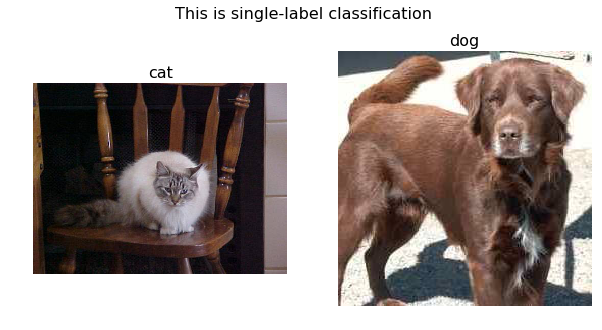

In [13]:
path = "data/dogscats/valid/"
list_paths = [f"{path}cats/cat.2039.jpg", f"{path}dogs/dog.5891.jpg"]
title = "This is single-label classification"
plots_from_files(list_paths, titles=["cat", "dog"], maintitle=title)

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

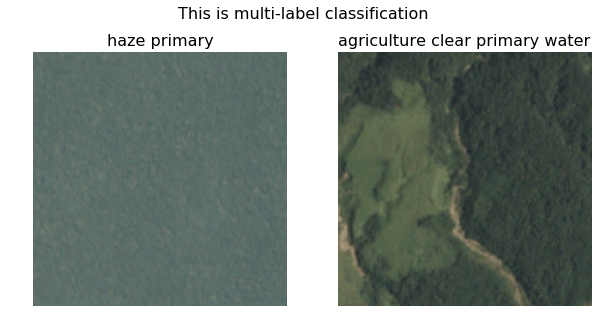

In [15]:
path = "data/planet/train-jpg/"
list_paths = [f"{path}train_0.jpg", f"{path}train_1.jpg"]
title = "This is multi-label classification"
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle=title)

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

### Planet data

### First model

In [ ]:
from planet import f2

sz=256
metrics=[f2]
f_model = resnet34
PATH = "data/planet/"

In [ ]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [ ]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                            suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [ ]:
learn = ConvLearner.pretrained(f_model, data, precompute=True, metrics=metrics)

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(0.2, 2)

In [ ]:
learn.fit(0.2, 15)

In [ ]:
learn.precompute=False
learn.fit(0.2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.unfreeze()
lrs = np.array([0.02,0.07,0.2])
learn.precompute=False

In [ ]:
learn.save('256_fc')

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_loss()

### Increasing resolution during training

In [ ]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [ ]:
data = get_data(256)
learn = ConvLearner.pretrained(f_model, data, precompute=True, metrics=metrics)
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 0.2
lrs = np.array([lr/10, lr/3, lr])
learn.precompute=False

In [ ]:
def train_sz(sz):
    learn.set_data(get_data(sz))
    learn.freeze()
    learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
    learn.unfreeze()
    learn.save(f'{sz}_fc')
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
    learn.save(f'{sz}')

In [ ]:
for sz in (64,128,256):
    print(sz)
    train_sz(sz)
    print('----')